In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from keras.applications import ResNet50, InceptionV3
from sklearn.utils import resample
from PIL import UnidentifiedImageError  # Import UnidentifiedImageError
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load data with error handling for invalid image files
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            try:
                # Only load if it's a valid image file
                image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
                image_array = img_to_array(image)
                images.append(image_array)
                labels.append(label)
            except UnidentifiedImageError:
                print(f"UnidentifiedImageError: Could not load {image_path}, skipping.")
            except Exception as e:
                print(f"Error: {e} while loading {image_path}, skipping.")
    return np.array(images), np.array(labels)

folder_path = "D:/DL Project/datasets/Oral cancer Dataset 2.0"
images, labels = load_data(folder_path)

d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\101.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\200.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\273.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\317.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\328.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\407.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\450.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\455.jpeg, skipping.
UnidentifiedImageError: Could not load D:/DL Project/datasets/Oral cancer Dataset 2.0\cancer\481

In [3]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

In [5]:
# Define and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

In [6]:
for layer in base_model.layers:
    layer.trainable = False  # Freeze the layers of ResNet50

In [7]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (cancer vs non-cancer)

In [8]:
model_ResNet50 = Model(inputs=base_model.input, outputs=predictions)

In [9]:
model_ResNet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 266, 266,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 130, 130,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 130, 130,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 130, 130,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 132, 132,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 65, 65,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 65, 65,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 65, 65,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 65, 65,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 65, 65,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 65, 65,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 65, 65,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 65, 65,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 65, 65,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 65, 65,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 65, 65,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
from tensorflow.keras.utils import plot_model
# Visualize the model architecture and save it as a file
plot_model(model_ResNet50, to_file='./architecture/resnet50_architecture.png', show_shapes=True, show_layer_names=True)



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.579035 to fit



In [12]:
model_ResNet50.compile(loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
                       optimizer='adam')


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [14]:
checkpoint_filepath = './models/best_model_resnet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [15]:
# Train the model
history = model_ResNet50.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6676 - loss: 1.5128 - precision: 0.6568 - recall: 0.7112
Epoch 1: val_accuracy improved from -inf to 0.85638, saving model to ./models/best_model_resnet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.6708 - loss: 1.4924 - precision: 0.6601 - recall: 0.7122 - val_accuracy: 0.8564 - val_loss: 0.3181 - val_precision: 0.8172 - val_recall: 0.8837 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8692 - loss: 0.2839 - precision: 0.8381 - recall: 0.9056
Epoch 2: val_accuracy improved from 0.85638 to 0.89362, saving model to ./models/best_model_resnet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8705 - loss: 0.2820 - precision: 0.8402 - recall: 0.9056 - val_accuracy: 0.8936 - val_loss: 0.2560 - val_precision: 0.8511 - val_recall: 0.9302 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9305 - loss: 0.1813 - precision: 0.9369 - recal

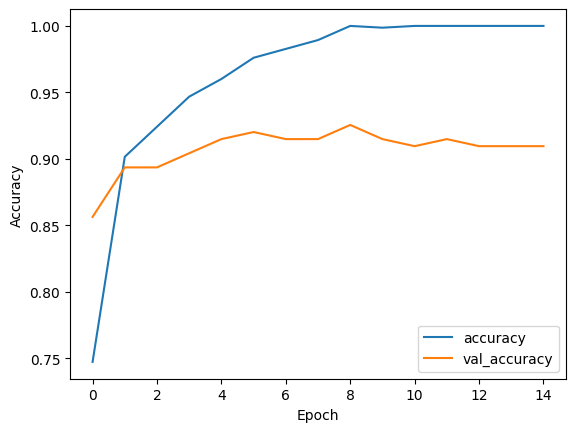

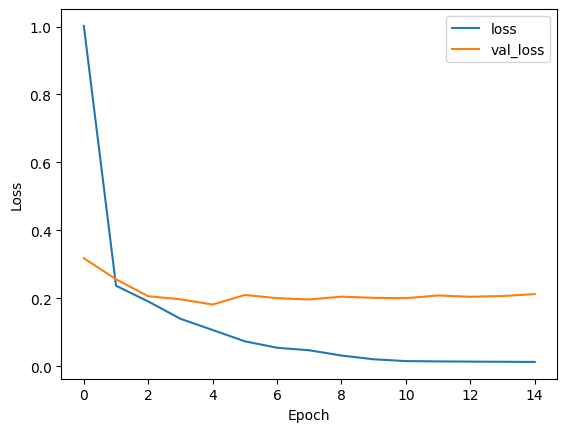

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [17]:
# Evaluate the model on the test set
evaluation = model_ResNet50.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9178 - loss: 0.1714 - precision: 0.8959 - recall: 0.9240
Test Loss: 0.18161380290985107
Test Accuracy: 0.914893627166748
Test Precision: 0.8977272510528564
Test Recall: 0.9186046719551086


In [18]:
# Load the best saved model
model_ResNet50.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model_ResNet50.evaluate(X_test, y_test, verbose=1)

# Print out the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9295 - loss: 0.1862 - precision: 0.8762 - recall: 0.9790
Test Loss: 0.2049
Test Accuracy: 0.9255
Test Precision: 0.8750
Test Recall: 0.9767


In [19]:
# Make predictions on the test set
y_pred = (model_ResNet50.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Non Cancer', 'Cancer'])
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
              precision    recall  f1-score   support

  Non Cancer       0.98      0.88      0.93       102
      Cancer       0.88      0.98      0.92        86

    accuracy                           0.93       188
   macro avg       0.93      0.93      0.93       188
weighted avg       0.93      0.93      0.93       188



In [20]:
y_pred

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
    

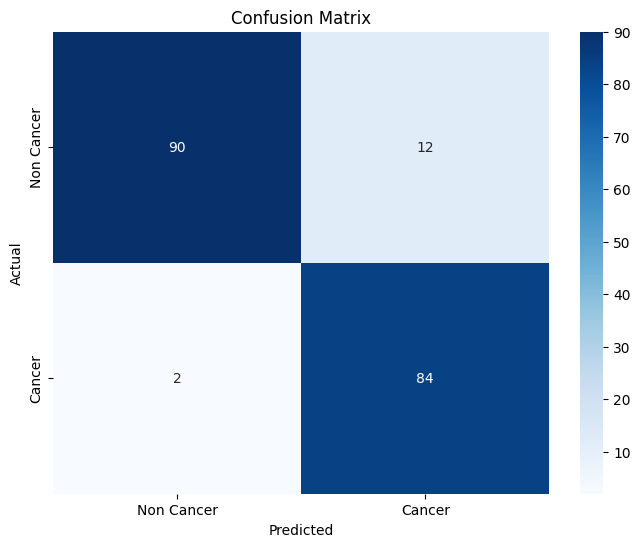

In [21]:
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cancer', 'Cancer'], yticklabels=['Non Cancer', 'Cancer'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

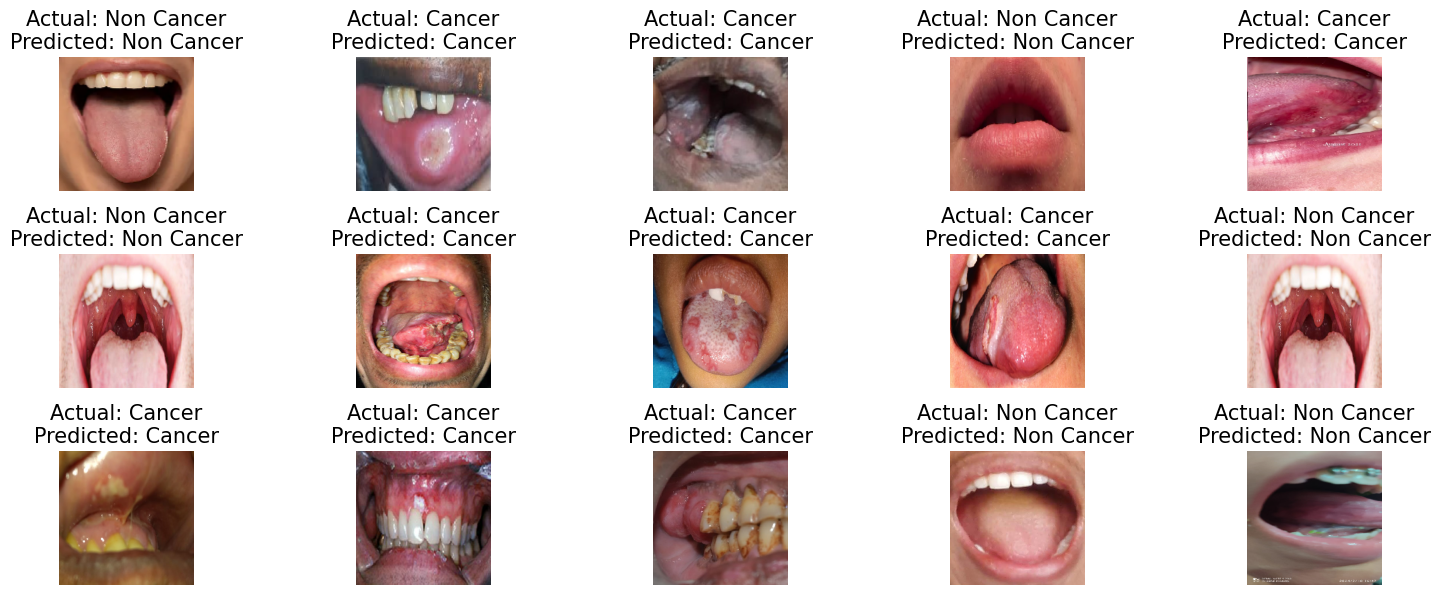

In [22]:
import matplotlib.pyplot as plt

def display_images_with_predictions(X_test, y_test, y_pred, num_images=10):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)  # Adjust the layout as needed
        plt.imshow(X_test[i].astype('uint8'))  # Convert to uint8 for correct display
        plt.axis('off')
        
        # Display actual and predicted labels
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if y_pred[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPredicted: {predicted}', fontsize=15)

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_images_with_predictions(X_test, y_test, y_pred, num_images=15)  # Display 15 images


In [23]:
def evaluate_model(model, new_data_path):
    new_images, new_labels = load_data(new_data_path)
    predictions = model.predict(new_images)
    predicted_classes = (predictions > 0.5).astype(int)

    # Evaluate the model
    accuracy = np.mean(predicted_classes.flatten() == new_labels.flatten())
    print(f"Accuracy on new data: {accuracy * 100:.2f}%")

# Call the evaluation function with the path to new data
evaluate_model(model_ResNet50, "D:/DL PRoject/test")


d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step
Accuracy on new data: 98.20%


16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step


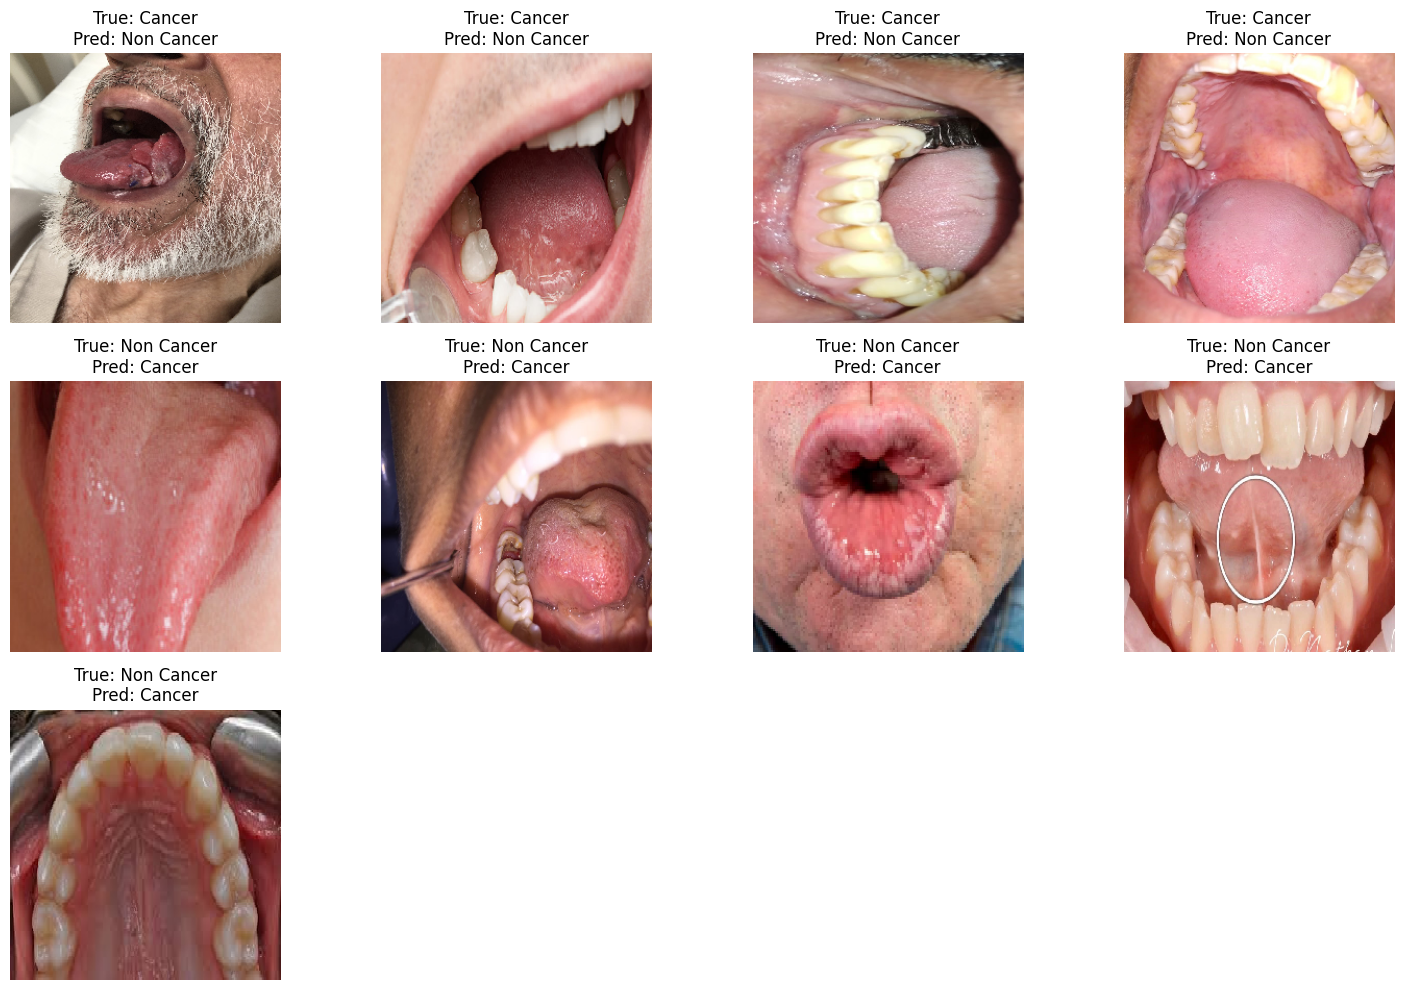

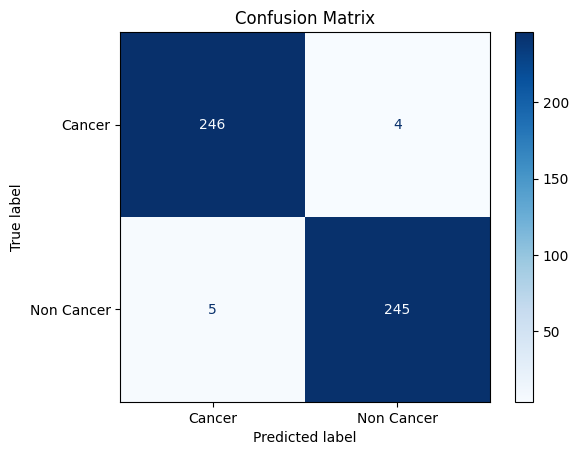

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.98      0.98       250
  Non Cancer       0.98      0.98      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

Saved misclassified image: D:/DL Project/misclassified_images/image_0.png
Saved misclassified image: D:/DL Project/misclassified_images/image_1.png
Saved misclassified image: D:/DL Project/misclassified_images/image_2.png
Saved misclassified image: D:/DL Project/misclassified_images/image_3.png
Saved misclassified image: D:/DL Project/misclassified_images/image_4.png
Saved misclassified image: D:/DL Project/misclassified_images/image_5.png
Saved misclassified image: D:/DL Project/misclassified_images/image_6.png
Saved misclassified image: D:/DL Project/misclassified_images/image_7.png
Saved misclassified image: D:/DL Project/misclassified_im

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to analyze misclassifications and generate classification report
def analyze_misclassifications(model, data_path):
    new_images, new_labels = load_data(data_path)
    predictions = model.predict(new_images)
    predicted_classes = (predictions > 0.5).astype(int)

    # Identify misclassified images
    misclassified_indices = np.where(predicted_classes.flatten() != new_labels.flatten())[0]

    # Display misclassified images
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(misclassified_indices[:10]):  # Display first 10 misclassified images
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_images[idx].astype('uint8'))
        plt.axis('off')
        plt.title(f'True: {"Cancer" if new_labels[idx] == 0 else "Non Cancer"}\nPred: {"Cancer" if predicted_classes[idx][0] == 0 else "Non Cancer"}')

    plt.tight_layout()
    plt.show()

    # Generate and display confusion matrix
    cm = confusion_matrix(new_labels, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(new_labels, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Optionally, save misclassified images for retraining
    misclassified_images = new_images[misclassified_indices]
    misclassified_labels = new_labels[misclassified_indices]
    for i, idx in enumerate(misclassified_indices):
        # Save misclassified images to a specific directory for further analysis
        save_path = f"D:/DL Project/misclassified_images/image_{i}.png"
        plt.imsave(save_path, new_images[idx].astype('uint8'))
        print(f"Saved misclassified image: {save_path}")

# Call the function to analyze misclassifications
analyze_misclassifications(model_ResNet50, "D:/DL Project/test")


d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
Accuracy: 0.9820


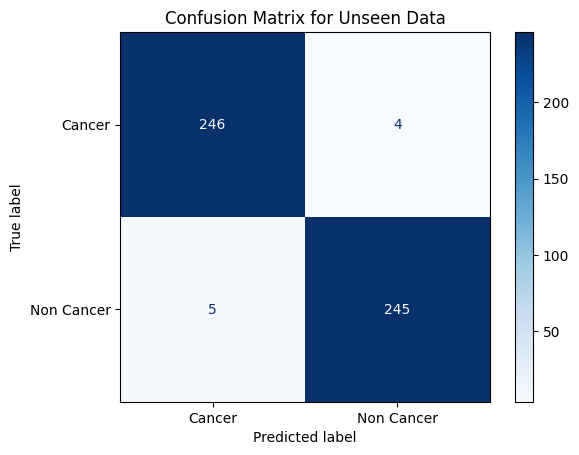

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.98      0.98       250
  Non Cancer       0.98      0.98      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



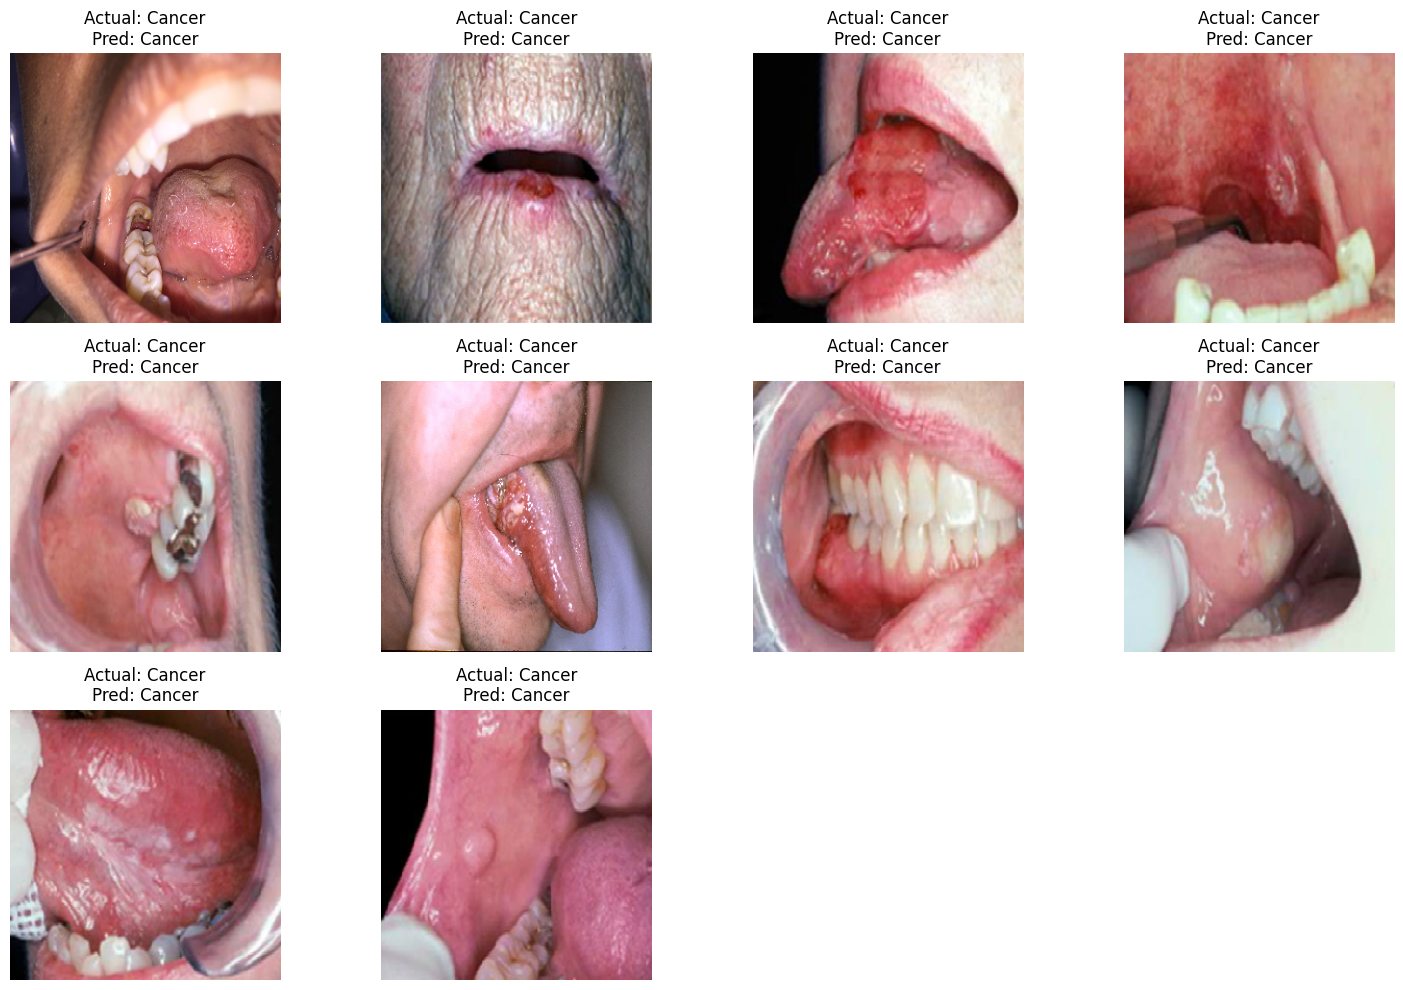

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to evaluate the model on unseen images
def evaluate_model(model, test_data_path):
    # Load new unseen data
    X_test, y_test = load_data(test_data_path)
    
    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = np.mean(predicted_classes.flatten() == y_test.flatten())
    print(f'Accuracy: {accuracy:.4f}')

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Unseen Data')
    plt.show()

    report = classification_report(y_test, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Visualize some predictions
    num_images = 10  # Adjust the number of images to display
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[i].astype('uint8'))
        plt.axis('off')
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if predicted_classes[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPred: {predicted}')

    plt.tight_layout()
    plt.show()

# Call the function to evaluate the model on unseen images
evaluate_model(model_ResNet50, "D:/DL Project/test")  # Specify the path to the unseen test data


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


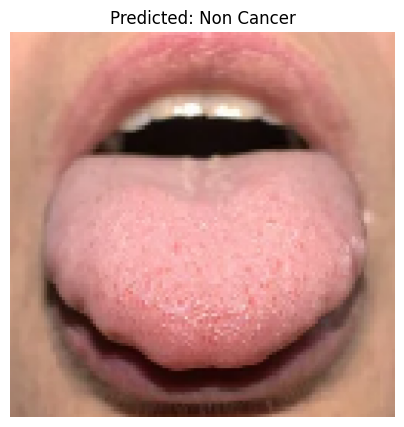

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path, true_label=None):
    # Load the image
    image = load_single_image(image_path)
    
    # Make predictions
    prediction = model.predict(image)
    predicted_class = 0 if prediction < 0.5 else 1  # 0 for Cancer, 1 for Non Cancer
    
    # Map predictions to labels
    predicted_label = 'Cancer' if predicted_class == 0 else 'Non Cancer'
    
    # Display the image with the prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0].astype('uint8'))  # Remove batch dimension for visualization
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}', fontsize=12)
    plt.show()

# Example usage with the model
# Provide the correct image path and true label (0 for Cancer, 1 for Non Cancer) if available
evaluate_single_image(model_ResNet50, "D:/DL PRoject/test/NON CANCER/010.jpeg", true_label=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


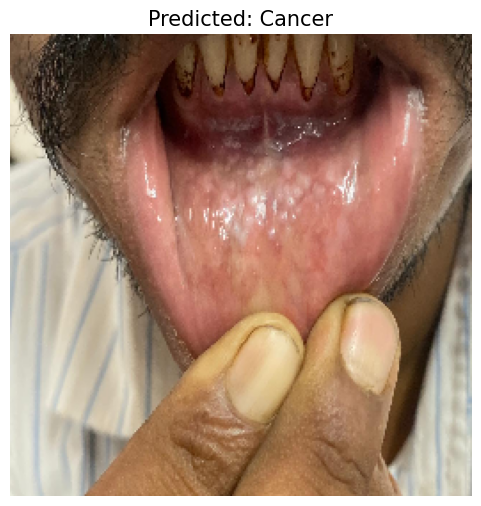

Predicted label for the image: Cancer


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    return np.expand_dims(image_array, axis=0)  # Expand dimensions to match model input shape

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path):
    # Load the single image
    X_single = load_single_image(image_path)
    
    # Make prediction
    prediction = model.predict(X_single)
    predicted_class = (prediction > 0.5).astype(int)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(X_single[0].astype('uint8'))
    plt.axis('off')
    
    # Display the prediction
    predicted_label = "Cancer" if predicted_class[0][0] == 0 else "Non Cancer"
    plt.title(f'Predicted: {predicted_label}', fontsize=15)
    plt.show()

    # Return the predicted label for further use if needed
    return predicted_label

# Specify the path to the single image
image_path = "D:/DL PRoject/test/CANCER/078.jpeg"  # Update the path to your image

# Call the function to evaluate the single image
predicted_label = evaluate_single_image(model_ResNet50, image_path)
print(f'Predicted label for the image: {predicted_label}')


In [28]:
# Save the trained model
model_ResNet50.save('./prediction/resnet50_oral_cancer_model.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


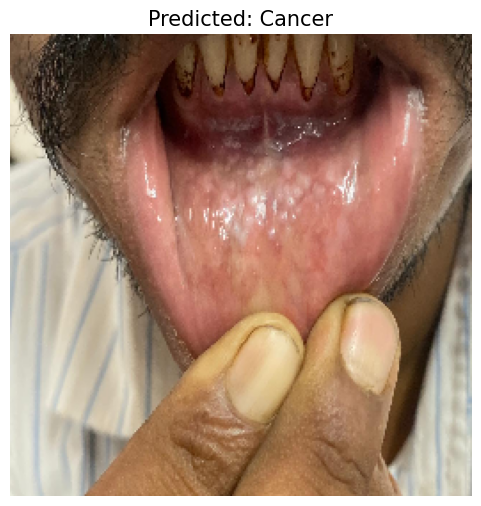

Predicted label for the image: Cancer


In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the saved ResNet model
model_path = "./prediction/resnet50_oral_cancer_model.keras"  # Update with your model's path
model_ResNet50 = load_model(model_path)

# Function to load and preprocess a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    return np.expand_dims(image_array, axis=0)  # Expand dimensions to match model input shape

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path):
    # Load the single image
    X_single = load_single_image(image_path)
    
    # Make prediction
    prediction = model.predict(X_single)
    predicted_class = (prediction > 0.5).astype(int)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(X_single[0].astype('uint8'))
    plt.axis('off')
    
    # Display the prediction
    predicted_label = "Cancer" if predicted_class[0][0] == 0 else "Non Cancer"
    plt.title(f'Predicted: {predicted_label}', fontsize=15)
    plt.show()

    # Return the predicted label for further use if needed
    return predicted_label

# Specify the path to the single image
image_path = "D:/DL PRoject/test/CANCER/078.jpeg"  # Update the path to your image

# Call the function to evaluate the single image
predicted_label = evaluate_single_image(model_ResNet50, image_path)
print(f'Predicted label for the image: {predicted_label}')


In [30]:
# Load the saved ResNet model
model_path = "./prediction/resnet50_oral_cancer_model.keras"  # Update with your model's path
model_ResNet50 = load_model(model_path)

d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step
Accuracy: 0.9820


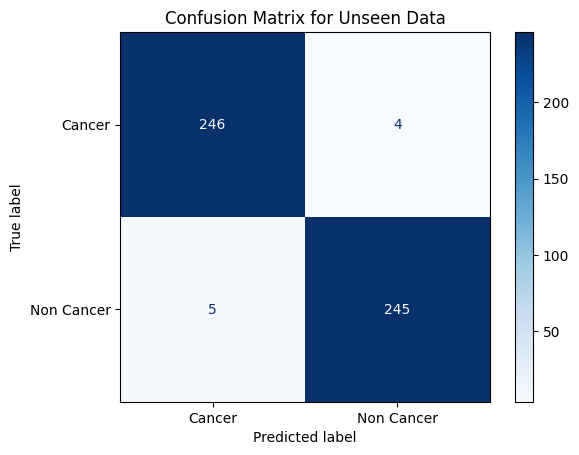

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.98      0.98       250
  Non Cancer       0.98      0.98      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



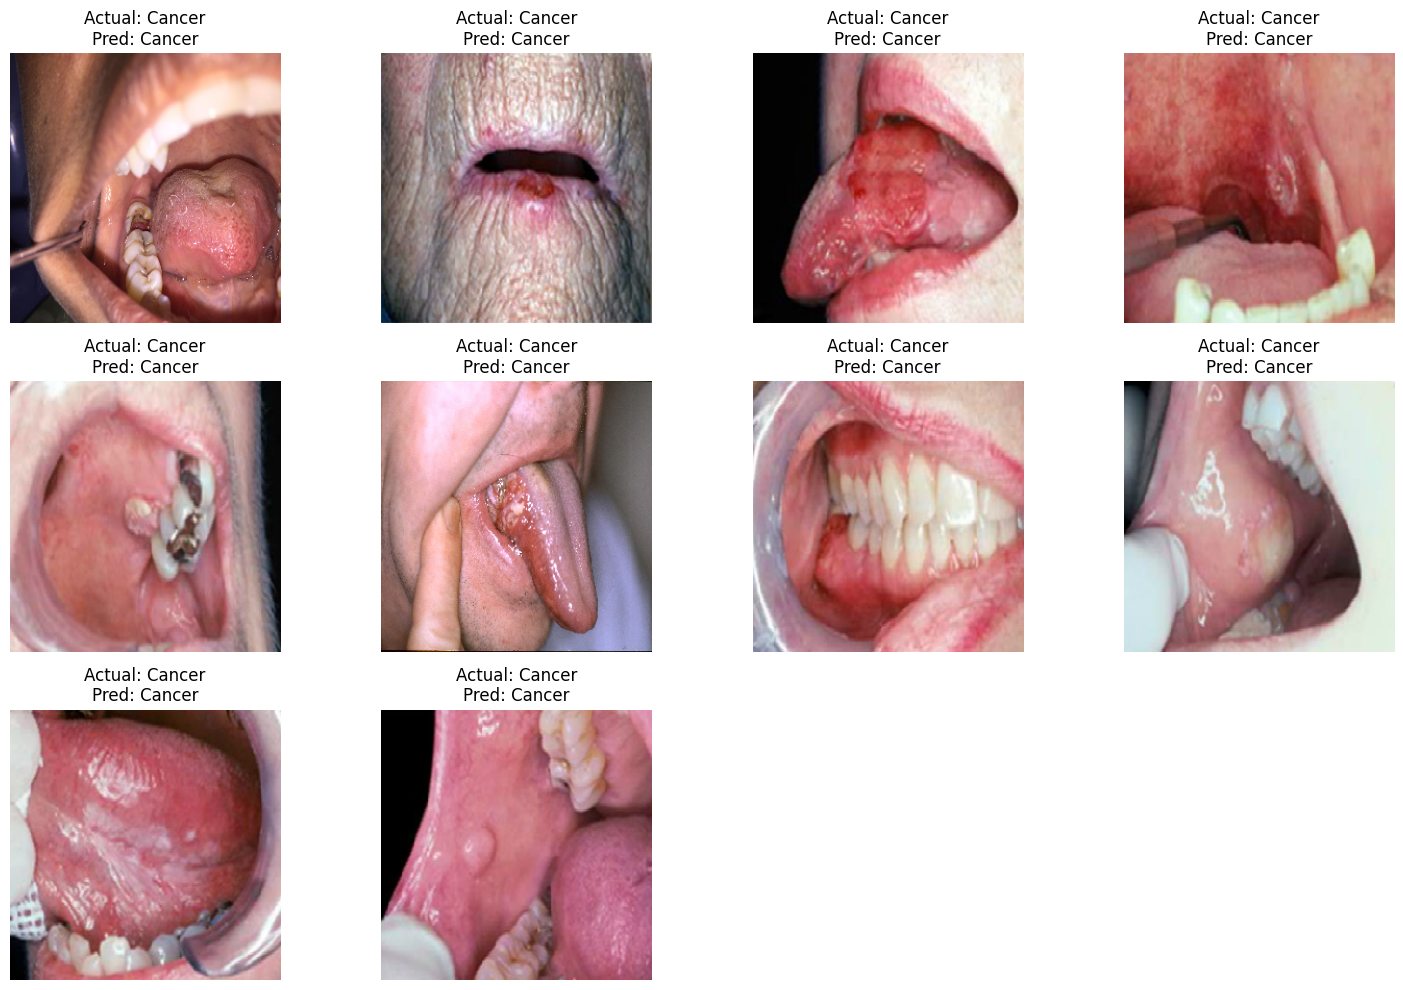

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to evaluate the model on unseen images
def evaluate_model(model, test_data_path):
    # Load new unseen data
    X_test, y_test = load_data(test_data_path)
    
    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = np.mean(predicted_classes.flatten() == y_test.flatten())
    print(f'Accuracy: {accuracy:.4f}')

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Unseen Data')
    plt.show()

    report = classification_report(y_test, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Visualize some predictions
    num_images = 10  # Adjust the number of images to display
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[i].astype('uint8'))
        plt.axis('off')
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if predicted_classes[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPred: {predicted}')

    plt.tight_layout()
    plt.show()

# Call the function to evaluate the model on unseen images
evaluate_model(model_ResNet50, "D:/DL Project/test")  # Specify the path to the unseen test data


In [32]:
def evaluate_model(model, new_data_path):
    new_images, new_labels = load_data(new_data_path)
    predictions = model.predict(new_images)
    
    # Predicted classes based on a threshold of 0.5
    predicted_classes = (predictions > 0.5).astype(int)

    # Evaluate the model
    accuracy = np.mean(predicted_classes.flatten() == new_labels.flatten())
    print(f"Accuracy on new data: {accuracy * 100:.2f}%")

    # Initialize counters for probabilities
    total_cancer_probability = 0
    total_non_cancer_probability = 0
    total_images = len(new_images)

    # Display prediction probabilities and predicted classes for each image
    for i in range(total_images):
        probability = predictions[i][0]  # Probability for the positive class (Cancer)
        predicted_class = "Cancer" if predicted_classes[i][0] == 0 else "Non Cancer"

        
        # Accumulate probabilities
        total_cancer_probability += probability
        total_non_cancer_probability += (1 - probability)  # Probability for Non Cancer

    # Calculate total percentage
    average_cancer_probability = (total_cancer_probability / total_images) * 100
    average_non_cancer_probability = (total_non_cancer_probability / total_images) * 100

    # Display total probabilities
    print(f"\nTotal Average Probability of Cancer: {average_cancer_probability:.2f}%")
    print(f"Total Average Probability of Non Cancer: {average_non_cancer_probability:.2f}%")

# Call the evaluation function with the path to new data
evaluate_model(model_ResNet50, "D:/DL PRoject/test")


d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step
Accuracy on new data: 98.20%

Total Average Probability of Cancer: 49.50%
Total Average Probability of Non Cancer: 50.50%
